In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, train_test_split
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
def print_classification_report(y, y_pred, y_pred_proba):
    matriz_confusion = confusion_matrix(y,y_pred)
    matriz_confusion_df = pd.DataFrame(matriz_confusion, index=['False','True'], columns=['False','True'])
    print(matriz_confusion_df)
    accuracy= accuracy_score(y, y_pred)
    print(" ")
    print(f"Accuracy: {accuracy}")
    precision = precision_score(y, y_pred)
    print(f"Precision: {precision}")
    recall = recall_score(y, y_pred)
    print(f"Recall: {recall}")
    auc = roc_auc_score(y, y_pred_proba)
    print(f"Area bajo la curva: {auc}")

In [3]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas

# LECTURA DEL FICHERO

In [4]:
diabetes_df = pd.read_csv('diabetes.csv')

# ANÁLISIS DE DATOS

## INFO
Primero realizamos un info de los datos que nos da información sobre las columnas que tiene el dataset, el tipo de datos que tienen y el número de valores no nulos.

In [5]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## HEAD 

De esta manera se puede contrastar que los tipos de datos que nos muestra info son correctos, además de hacernos una primera idea de las magnitudes que tiene cada variable.

In [6]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## DESCRIBE

Obtendremos información estadística de cada una de las variables continuas. Dependiendo de las distribuciones de los datos y el modelos a aplicar nos puede dar una idea de la necesidad de escalar las variables y cómo hacerlo



In [7]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## HIST

Vamos a mostrar la distribución de cada variable con un histograma. Para la variable objetivo nos puede dar una idea de nivel de balanceo que tiene

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

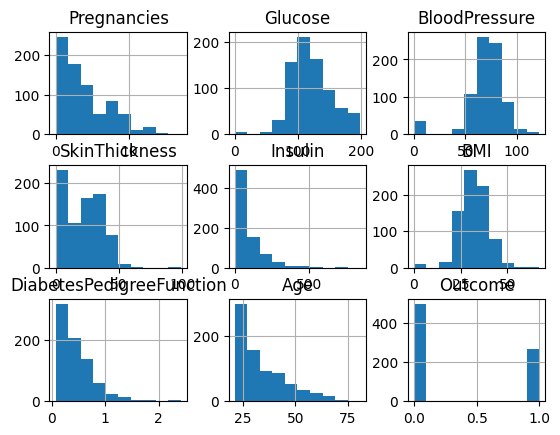

In [8]:
diabetes_df.hist()

## CORRELACIONES

Vamos a mostrar el nivel de correlaciones de cada variable con la variable objetivo. Primero de manera numérica y luego con un boxplot de cada variable agrupando por la cariable objetivo. Es importante revisar las correlaciones de manera gráfica ya que los datos numéricos pueden verse impactados por valores atípicos.

In [9]:
diabetes_df.corr()['Outcome']

Pregnancies                 0.221898
Glucose                     0.466581
BloodPressure               0.065068
SkinThickness               0.074752
Insulin                     0.130548
BMI                         0.292695
DiabetesPedigreeFunction    0.173844
Age                         0.238356
Outcome                     1.000000
Name: Outcome, dtype: float64

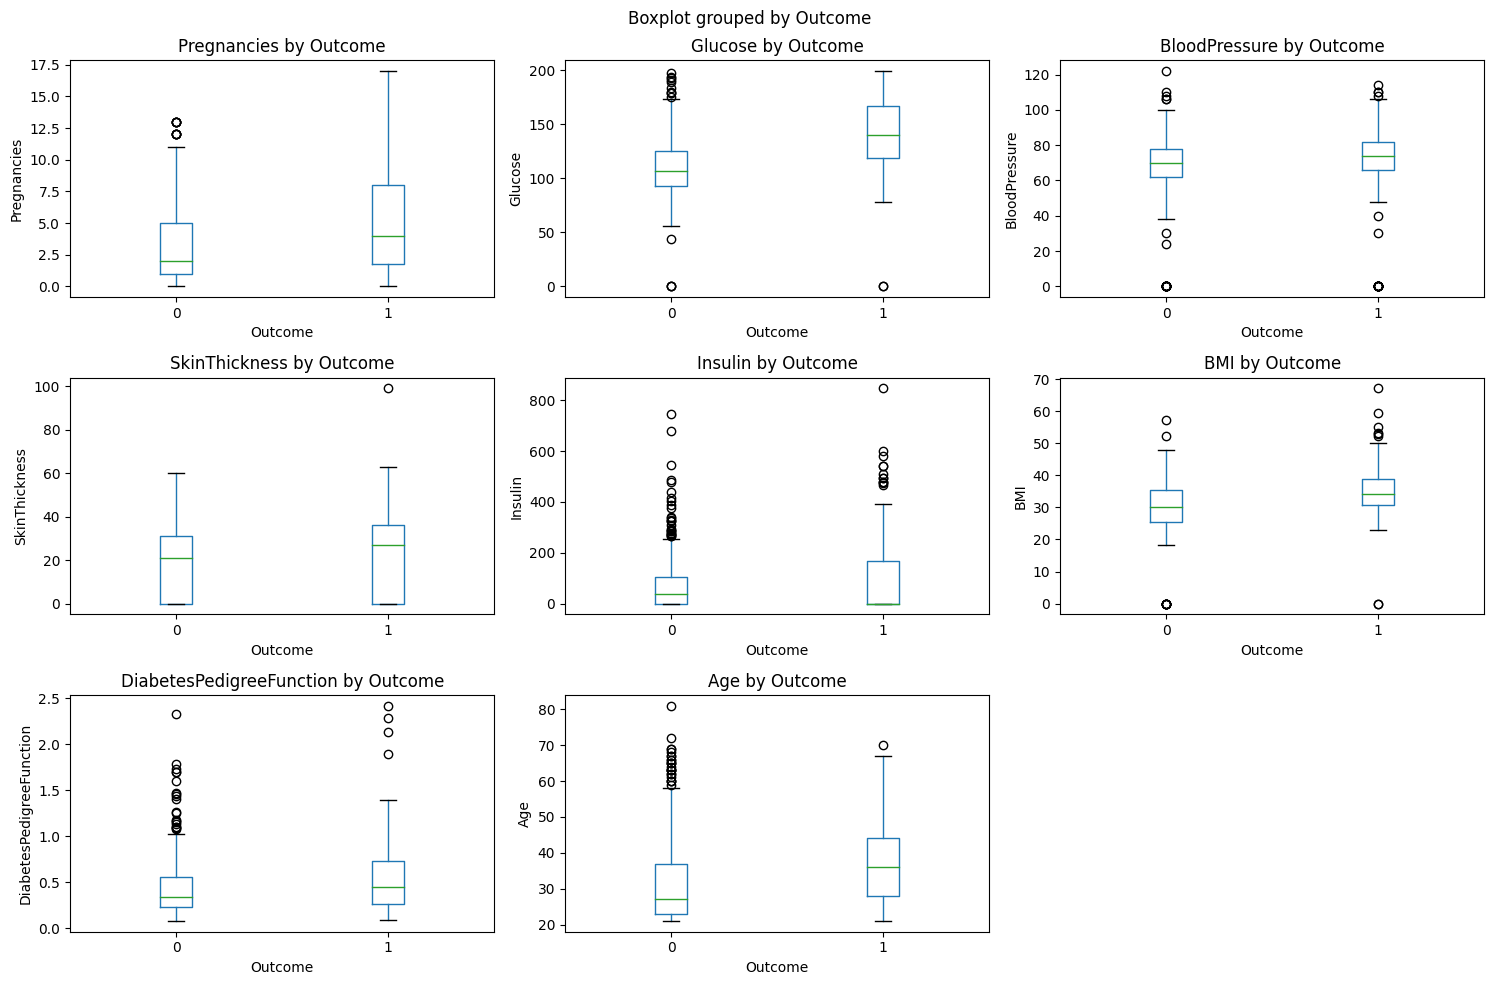

In [10]:
# Excluye la columna 'Outcome' para crear gráficos de caja para las demás
columns = diabetes_df.columns[:-1]
outcome = diabetes_df['Outcome']

# Configurar el número de filas y columnas de subplots
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Aplanar el arreglo de ejes para iterar fácilmente (si es necesario)
axes = axes.flatten()

# Crear gráficos de caja por cada columna
for i, col in enumerate(columns):
    ax = axes[i]
    diabetes_df.boxplot(column=[col], by='Outcome', ax=ax, grid=False)
    ax.set_title(f'{col} by Outcome')
    ax.set_xlabel('Outcome')
    ax.set_ylabel(col)

# Quitar gráficos sobrantes si hay menos columnas que subplots
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

# Ajustar el diseño
plt.tight_layout()
plt.show()

# SEPARACIÓN DE VARIABLES INDEPENDIENTES Y VARIABLE DEPENDIENTE

In [11]:
X = diabetes_df[['Glucose','BMI']]
y = diabetes_df['Outcome']

# MODELO 

## ÁRBOL DE DECISIÓN

[Text(0.5, 0.75, 'Glucose <= 127.5\ngini = 0.454\nsamples = 768\nvalue = [500, 268]'),
 Text(0.25, 0.25, 'gini = 0.313\nsamples = 485\nvalue = [391, 94]'),
 Text(0.75, 0.25, 'gini = 0.474\nsamples = 283\nvalue = [109, 174]')]

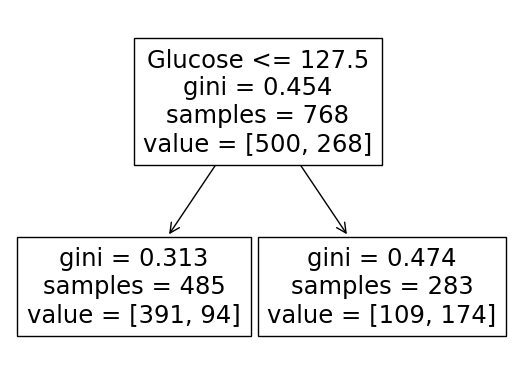

In [12]:
cdt = DecisionTreeClassifier(max_depth=1)
cdt.fit(X,y)
y_pred = cdt.predict(X)
plot_tree(cdt,feature_names=X.columns)

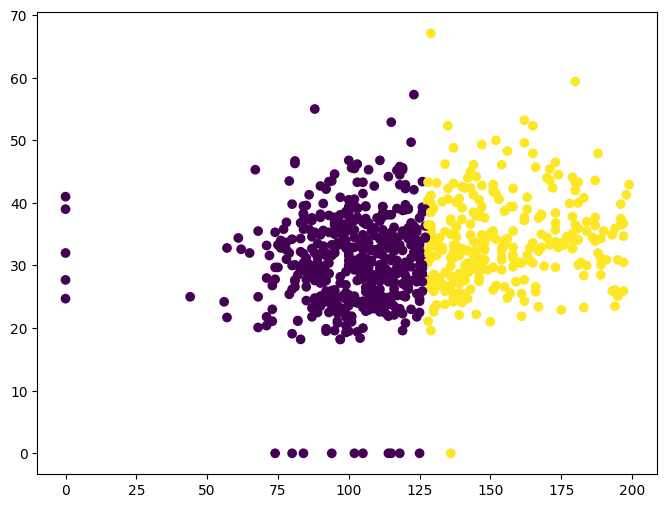

In [13]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X['Glucose'], X['BMI'], c=y_pred, cmap='viridis')

[Text(0.5, 0.8333333333333334, 'Glucose <= 127.5\ngini = 0.454\nsamples = 768\nvalue = [500, 268]'),
 Text(0.25, 0.5, 'BMI <= 26.95\ngini = 0.313\nsamples = 485\nvalue = [391, 94]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.056\nsamples = 140\nvalue = [136, 4]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.386\nsamples = 345\nvalue = [255, 90]'),
 Text(0.75, 0.5, 'BMI <= 29.95\ngini = 0.474\nsamples = 283\nvalue = [109, 174]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.432\nsamples = 76\nvalue = [52, 24]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.399\nsamples = 207\nvalue = [57, 150]')]

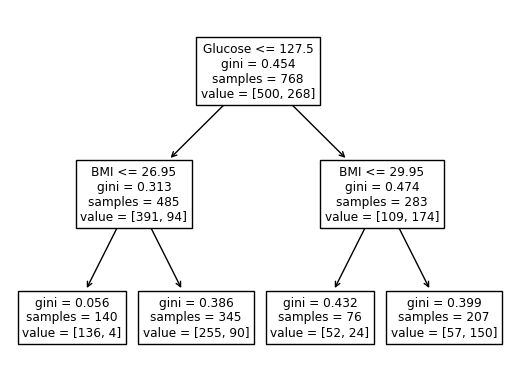

In [14]:
cdt = DecisionTreeClassifier(max_depth=2)
cdt.fit(X,y)
y_pred = cdt.predict(X)
plot_tree(cdt,feature_names=X.columns)

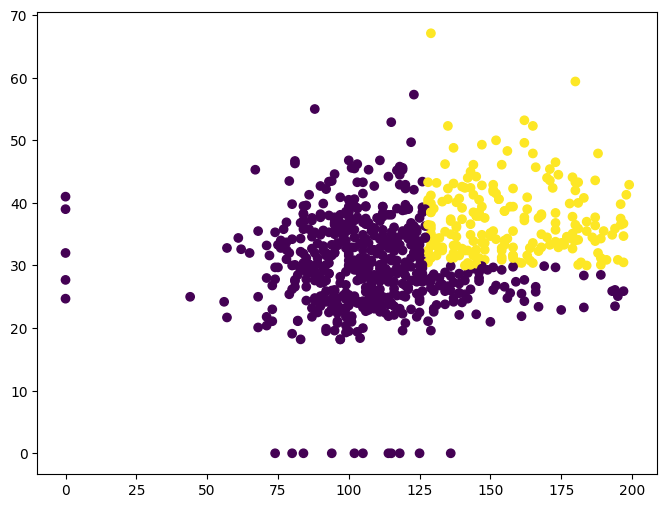

In [15]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X['Glucose'], X['BMI'], c=y_pred, cmap='viridis')

[Text(0.485311329588015, 0.9545454545454546, 'Glucose <= 127.5\ngini = 0.454\nsamples = 768\nvalue = [500, 268]'),
 Text(0.19112827715355804, 0.8636363636363636, 'BMI <= 26.95\ngini = 0.313\nsamples = 485\nvalue = [391, 94]'),
 Text(0.04868913857677903, 0.7727272727272727, 'BMI <= 9.1\ngini = 0.056\nsamples = 140\nvalue = [136, 4]'),
 Text(0.0149812734082397, 0.6818181818181818, 'Glucose <= 114.5\ngini = 0.32\nsamples = 10\nvalue = [8, 2]'),
 Text(0.00749063670411985, 0.5909090909090909, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]'),
 Text(0.02247191011235955, 0.5909090909090909, 'Glucose <= 116.5\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.0149812734082397, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.0299625468164794, 0.5, 'Glucose <= 121.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.02247191011235955, 0.4090909090909091, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.03745318352059925, 0.4090909090909091, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 T

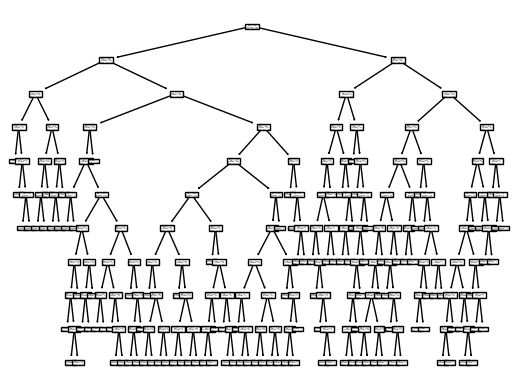

In [16]:
cdt = DecisionTreeClassifier(max_depth=10)
cdt.fit(X,y)
y_pred = cdt.predict(X)
plot_tree(cdt,feature_names=X.columns)

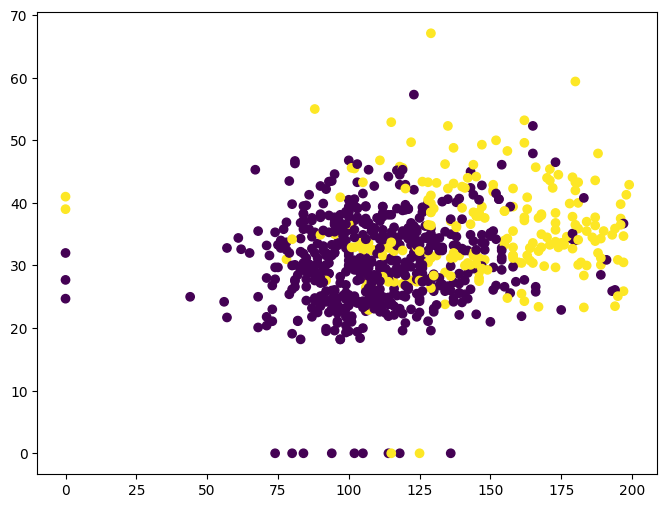

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(X['Glucose'], X['BMI'], c=y_pred, cmap='viridis')

[Text(0.5083333333333333, 0.95, 'Glucose <= 127.5\ngini = 0.454\nsamples = 768\nvalue = [500, 268]'),
 Text(0.23333333333333334, 0.85, 'BMI <= 26.95\ngini = 0.313\nsamples = 485\nvalue = [391, 94]'),
 Text(0.06666666666666667, 0.75, 'BMI <= 9.1\ngini = 0.056\nsamples = 140\nvalue = [136, 4]'),
 Text(0.03333333333333333, 0.65, 'gini = 0.32\nsamples = 10\nvalue = [8, 2]'),
 Text(0.1, 0.65, 'BMI <= 26.45\ngini = 0.03\nsamples = 130\nvalue = [128, 2]'),
 Text(0.06666666666666667, 0.55, 'BMI <= 22.95\ngini = 0.016\nsamples = 122\nvalue = [121, 1]'),
 Text(0.03333333333333333, 0.45, 'gini = 0.046\nsamples = 42\nvalue = [41, 1]'),
 Text(0.1, 0.45, 'gini = 0.0\nsamples = 80\nvalue = [80, 0]'),
 Text(0.13333333333333333, 0.55, 'gini = 0.219\nsamples = 8\nvalue = [7, 1]'),
 Text(0.4, 0.75, 'Glucose <= 99.5\ngini = 0.386\nsamples = 345\nvalue = [255, 90]'),
 Text(0.23333333333333334, 0.65, 'BMI <= 50.85\ngini = 0.216\nsamples = 130\nvalue = [114, 16]'),
 Text(0.2, 0.55, 'Glucose <= 28.5\ngini = 0

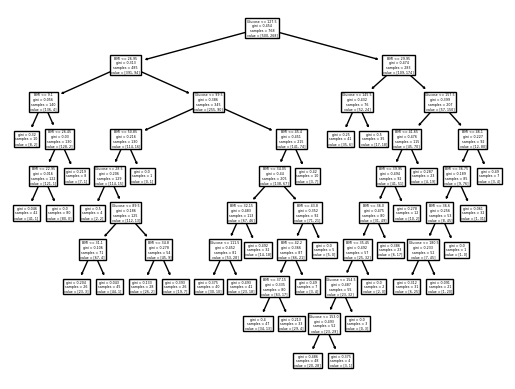

In [18]:
cdt = DecisionTreeClassifier(max_depth=10, min_samples_split=50)
cdt.fit(X,y)
y_pred = cdt.predict(X)
plot_tree(cdt,feature_names=X.columns)

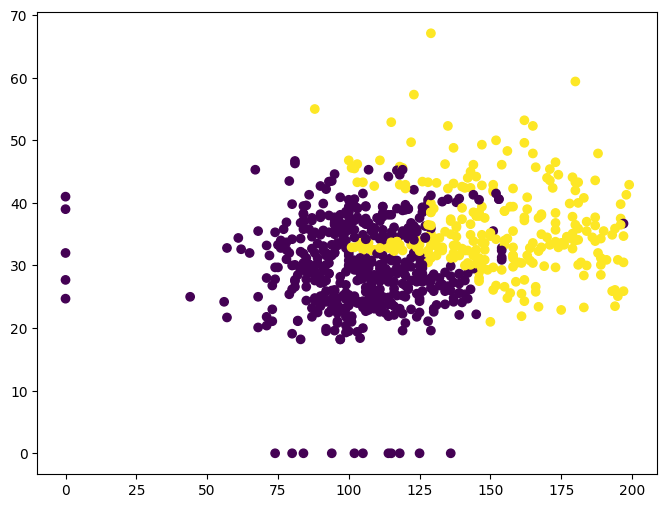

In [19]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X['Glucose'], X['BMI'], c=y_pred, cmap='viridis')

       False  True
False     78    21
True      18    37
 
Accuracy: 0.7467532467532467
Precision: 0.6379310344827587
Recall: 0.6727272727272727
Area bajo la curva: 0.7303030303030302


[Text(0.4611607142857143, 0.9642857142857143, 'x[1] <= 127.5\ngini = 0.453\nsamples = 614\nvalue = [401, 213]'),
 Text(0.16458333333333333, 0.8928571428571429, 'x[7] <= 28.5\ngini = 0.314\nsamples = 390\nvalue = [314, 76]'),
 Text(0.05952380952380952, 0.8214285714285714, 'x[5] <= 30.95\ngini = 0.142\nsamples = 221\nvalue = [204, 17]'),
 Text(0.01904761904761905, 0.75, 'x[6] <= 0.672\ngini = 0.016\nsamples = 124\nvalue = [123, 1]'),
 Text(0.009523809523809525, 0.6785714285714286, 'gini = 0.0\nsamples = 108\nvalue = [108, 0]'),
 Text(0.02857142857142857, 0.6785714285714286, 'x[6] <= 0.686\ngini = 0.117\nsamples = 16\nvalue = [15, 1]'),
 Text(0.01904761904761905, 0.6071428571428571, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.0380952380952381, 0.6071428571428571, 'gini = 0.0\nsamples = 15\nvalue = [15, 0]'),
 Text(0.1, 0.75, 'x[2] <= 37.0\ngini = 0.275\nsamples = 97\nvalue = [81, 16]'),
 Text(0.09047619047619047, 0.6785714285714286, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Tex

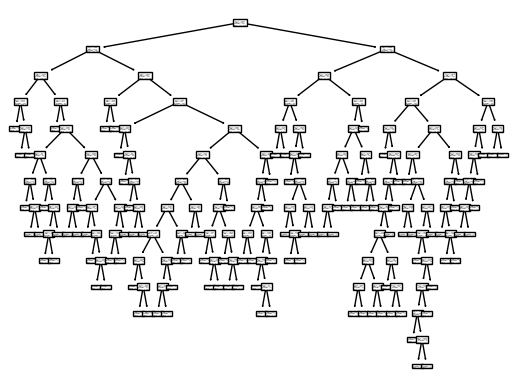

In [20]:
X = diabetes_df.drop(columns = ['Outcome'])
y = diabetes_df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cdt = DecisionTreeClassifier()
cdt.fit(X_train, y_train)
y_pred_proba = cdt.predict_proba(X_test)[:,1]
y_pred = y_pred_proba >= 0.5
print_classification_report(y_test, y_pred,y_pred_proba)
plot_tree(cdt)

In [21]:
X = diabetes_df.drop(columns = ['Outcome'])
y = diabetes_df['Outcome']

cdt = DecisionTreeClassifier(class_weight="balanced")
y_pred_proba = cross_val_predict(cdt, X, y, cv=5, method='predict_proba')[:,1]
y_pred = y_pred_proba >= 0.5
print_classification_report(y, y_pred, y_pred_proba)

       False  True
False    397   103
True     126   142
 
Accuracy: 0.7018229166666666
Precision: 0.5795918367346938
Recall: 0.5298507462686567
Area bajo la curva: 0.6619253731343284


In [22]:
parameters = {'max_depth': [3, 5, 10, 15],
               'min_samples_split': [1, 5, 10, 25, 50, 100],
               'min_samples_leaf': [5, 10, 25, 50, 100]}


cdt = DecisionTreeClassifier(class_weight="balanced")
scoring_metrics = ['accuracy','roc_auc', 'recall']
grid_searh = GridSearchCV(cdt, parameters, scoring=scoring_metrics, cv=5, refit='recall')
grid_searh.fit(X, y)
grid_search_results_df = pd.DataFrame(grid_searh.cv_results_)

/Users/trabajo/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
100 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/trabajo/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/trabajo/miniconda3/lib/python3.8/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/trabajo/miniconda3/lib/python3.8/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  Fi

In [23]:
grid_search_results_df['mean_result'] = 0.3*grid_search_results_df['mean_test_roc_auc'] + 0.7*grid_search_results_df['mean_test_recall']
grid_search_results_df.sort_values(by='mean_result',ascending=False,inplace=True)
grid_search_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,mean_result
13,0.001307,0.000020,0.001965,0.000050,3,25,5,"{'max_depth': 3, 'min_samples_leaf': 25, 'min_...",0.694805,0.662338,0.746753,0.699346,0.705882,0.701825,0.027017,58,0.790463,0.757037,0.796759,0.839528,0.805000,0.797758,0.026494,14,0.851852,0.851852,0.777778,0.886792,0.830189,0.839693,0.035883,9,0.827112
15,0.001329,0.000058,0.001948,0.000024,3,25,25,"{'max_depth': 3, 'min_samples_leaf': 25, 'min_...",0.694805,0.662338,0.746753,0.699346,0.705882,0.701825,0.027017,58,0.790463,0.757037,0.796759,0.839528,0.805000,0.797758,0.026494,14,0.851852,0.851852,0.777778,0.886792,0.830189,0.839693,0.035883,9,0.827112
14,0.001327,0.000038,0.001946,0.000022,3,25,10,"{'max_depth': 3, 'min_samples_leaf': 25, 'min_...",0.694805,0.662338,0.746753,0.699346,0.705882,0.701825,0.027017,58,0.790463,0.755926,0.796759,0.839528,0.805000,0.797535,0.026837,16,0.851852,0.851852,0.777778,0.886792,0.830189,0.839693,0.035883,9,0.827045
16,0.001345,0.000028,0.001952,0.000082,3,25,50,"{'max_depth': 3, 'min_samples_leaf': 25, 'min_...",0.694805,0.662338,0.746753,0.699346,0.705882,0.701825,0.027017,58,0.790463,0.755926,0.796759,0.839528,0.805000,0.797535,0.026837,16,0.851852,0.851852,0.777778,0.886792,0.830189,0.839693,0.035883,9,0.827045
2,0.001493,0.000152,0.002210,0.000226,3,5,10,"{'max_depth': 3, 'min_samples_leaf': 5, 'min_s...",0.694805,0.662338,0.688312,0.699346,0.692810,0.687522,0.013082,76,0.790463,0.756852,0.773241,0.839528,0.777264,0.787470,0.028154,53,0.851852,0.851852,0.777778,0.886792,0.849057,0.843466,0.035676,1,0.826667


In [24]:
cdt = DecisionTreeClassifier(class_weight="balanced", max_depth=3, min_samples_leaf=25, min_samples_split=10)
y_pred_proba = cross_val_predict(cdt, X, y, cv=5, method="predict_proba")[:,1]
y_pred = y_pred_proba >= 0.5
print_classification_report(y, y_pred, y_pred_proba)

       False  True
False    314   186
True      43   225
 
Accuracy: 0.7018229166666666
Precision: 0.5474452554744526
Recall: 0.8395522388059702
Area bajo la curva: 0.7989664179104479


## RANDOM FOREST

In [25]:
rft = RandomForestClassifier(class_weight="balanced")
y_pred_proba = cross_val_predict(rft, X, y, cv=5, method="predict_proba")[:,1]
y_pred = y_pred_proba>0.5
print_classification_report(y, y_pred, y_pred_proba)

       False  True
False    436    64
True     117   151
 
Accuracy: 0.7643229166666666
Precision: 0.7023255813953488
Recall: 0.5634328358208955
Area bajo la curva: 0.8247574626865672


In [26]:
param_grid = {
    'n_estimators': [100, 500, 1000,2000],
    'max_depth': [3, 4, 5],
    'min_samples_split': [5, 10, 50, 100],
    'min_samples_leaf': [5, 10, 50, 100]
}

grid_search = GridSearchCV(rft,param_grid,cv=5,scoring=scoring_metrics, refit='recall')
grid_searh.fit(X, y)
grid_search_results_df = pd.DataFrame(grid_searh.cv_results_)

/Users/trabajo/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
100 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/trabajo/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/trabajo/miniconda3/lib/python3.8/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/trabajo/miniconda3/lib/python3.8/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  Fi

In [27]:
grid_search_results_df['mean_result'] = 0.3*grid_search_results_df['mean_test_roc_auc'] + 0.7*grid_search_results_df['mean_test_recall']
grid_search_results_df.sort_values(by='mean_result',ascending=False,inplace=True)
grid_search_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,mean_result
15,0.001296,0.000009,0.001914,0.000023,3,25,25,"{'max_depth': 3, 'min_samples_leaf': 25, 'min_...",0.694805,0.662338,0.746753,0.699346,0.705882,0.701825,0.027017,58,0.790463,0.757037,0.796759,0.839528,0.805000,0.797758,0.026494,15,0.851852,0.851852,0.777778,0.886792,0.830189,0.839693,0.035883,9,0.827112
13,0.001326,0.000062,0.001937,0.000043,3,25,5,"{'max_depth': 3, 'min_samples_leaf': 25, 'min_...",0.694805,0.662338,0.746753,0.699346,0.705882,0.701825,0.027017,58,0.790463,0.755926,0.796759,0.839528,0.805000,0.797535,0.026837,17,0.851852,0.851852,0.777778,0.886792,0.830189,0.839693,0.035883,9,0.827045
14,0.001324,0.000067,0.001962,0.000093,3,25,10,"{'max_depth': 3, 'min_samples_leaf': 25, 'min_...",0.694805,0.662338,0.746753,0.699346,0.705882,0.701825,0.027017,58,0.790463,0.755926,0.796759,0.839528,0.805000,0.797535,0.026837,17,0.851852,0.851852,0.777778,0.886792,0.830189,0.839693,0.035883,9,0.827045
16,0.001292,0.000018,0.001932,0.000041,3,25,50,"{'max_depth': 3, 'min_samples_leaf': 25, 'min_...",0.694805,0.662338,0.746753,0.699346,0.705882,0.701825,0.027017,58,0.790463,0.755926,0.796759,0.839528,0.805000,0.797535,0.026837,17,0.851852,0.851852,0.777778,0.886792,0.830189,0.839693,0.035883,9,0.827045
2,0.002036,0.000524,0.003227,0.000611,3,5,10,"{'max_depth': 3, 'min_samples_leaf': 5, 'min_s...",0.694805,0.662338,0.688312,0.699346,0.692810,0.687522,0.013082,77,0.790463,0.756852,0.773241,0.839528,0.777264,0.787470,0.028154,53,0.851852,0.851852,0.777778,0.886792,0.849057,0.843466,0.035676,1,0.826667


In [28]:
rft = RandomForestClassifier(class_weight="balanced", max_depth=15, min_samples_leaf=50, min_samples_split=50,n_estimators=2000, random_state=43)
y_pred = cross_val_predict(rft, X, y, cv=5)
print_classification_report(y, y_pred,y_pred_proba)

       False  True
False    361   139
True      57   211
 
Accuracy: 0.7447916666666666
Precision: 0.6028571428571429
Recall: 0.7873134328358209
Area bajo la curva: 0.8247574626865672


## GRADIENT BOOSTING MACHINE

In [29]:
gbm = GradientBoostingClassifier()
y_pred_proba = cross_val_predict(gbm, X, y, method="predict_proba")[:,1]
y_pred = y_pred_proba > 0.5
print_classification_report(y,y_pred,y_pred_proba)

       False  True
False    422    78
True     108   160
 
Accuracy: 0.7578125
Precision: 0.6722689075630253
Recall: 0.5970149253731343
Area bajo la curva: 0.8247798507462687


In [30]:
gbm_param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [5, 10, 50, 100],
    'min_samples_leaf': [5, 10, 50, 100]
}

grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gbm_param_grid, scoring='recall', cv=5)
grid_search.fit(X, y)
grid_search_results_df = pd.DataFrame(grid_searh.cv_results_)

In [31]:
grid_search_results_df['mean_result'] = 0.3*grid_search_results_df['mean_test_roc_auc'] + 0.7*grid_search_results_df['mean_test_recall']
grid_search_results_df.sort_values(by='mean_result',ascending=False,inplace=True)
grid_search_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,mean_result
15,0.001296,0.000009,0.001914,0.000023,3,25,25,"{'max_depth': 3, 'min_samples_leaf': 25, 'min_...",0.694805,0.662338,0.746753,0.699346,0.705882,0.701825,0.027017,58,0.790463,0.757037,0.796759,0.839528,0.805000,0.797758,0.026494,15,0.851852,0.851852,0.777778,0.886792,0.830189,0.839693,0.035883,9,0.827112
13,0.001326,0.000062,0.001937,0.000043,3,25,5,"{'max_depth': 3, 'min_samples_leaf': 25, 'min_...",0.694805,0.662338,0.746753,0.699346,0.705882,0.701825,0.027017,58,0.790463,0.755926,0.796759,0.839528,0.805000,0.797535,0.026837,17,0.851852,0.851852,0.777778,0.886792,0.830189,0.839693,0.035883,9,0.827045
14,0.001324,0.000067,0.001962,0.000093,3,25,10,"{'max_depth': 3, 'min_samples_leaf': 25, 'min_...",0.694805,0.662338,0.746753,0.699346,0.705882,0.701825,0.027017,58,0.790463,0.755926,0.796759,0.839528,0.805000,0.797535,0.026837,17,0.851852,0.851852,0.777778,0.886792,0.830189,0.839693,0.035883,9,0.827045
16,0.001292,0.000018,0.001932,0.000041,3,25,50,"{'max_depth': 3, 'min_samples_leaf': 25, 'min_...",0.694805,0.662338,0.746753,0.699346,0.705882,0.701825,0.027017,58,0.790463,0.755926,0.796759,0.839528,0.805000,0.797535,0.026837,17,0.851852,0.851852,0.777778,0.886792,0.830189,0.839693,0.035883,9,0.827045
2,0.002036,0.000524,0.003227,0.000611,3,5,10,"{'max_depth': 3, 'min_samples_leaf': 5, 'min_s...",0.694805,0.662338,0.688312,0.699346,0.692810,0.687522,0.013082,77,0.790463,0.756852,0.773241,0.839528,0.777264,0.787470,0.028154,53,0.851852,0.851852,0.777778,0.886792,0.849057,0.843466,0.035676,1,0.826667


In [32]:
params = grid_search_results_df['params'].iloc[0]
print(params)

{'max_depth': 3, 'min_samples_leaf': 25, 'min_samples_split': 25}


In [33]:
gbm = GradientBoostingClassifier(learning_rate = 0.2, max_depth=5, subsample=1, min_samples_leaf=5, min_samples_split=5, n_estimators=100,random_state=42)
y_pred_proba = cross_val_predict(gbm, X, y,method = "predict_proba")[:,1]
y_pred = y_pred_proba >= 0.5
print_classification_report(y, y_pred, y_pred_proba)

       False  True
False    409    91
True      93   175
 
Accuracy: 0.7604166666666666
Precision: 0.6578947368421053
Recall: 0.6529850746268657
Area bajo la curva: 0.8029402985074626


# FEATURE IMPORTANCE

## MDI

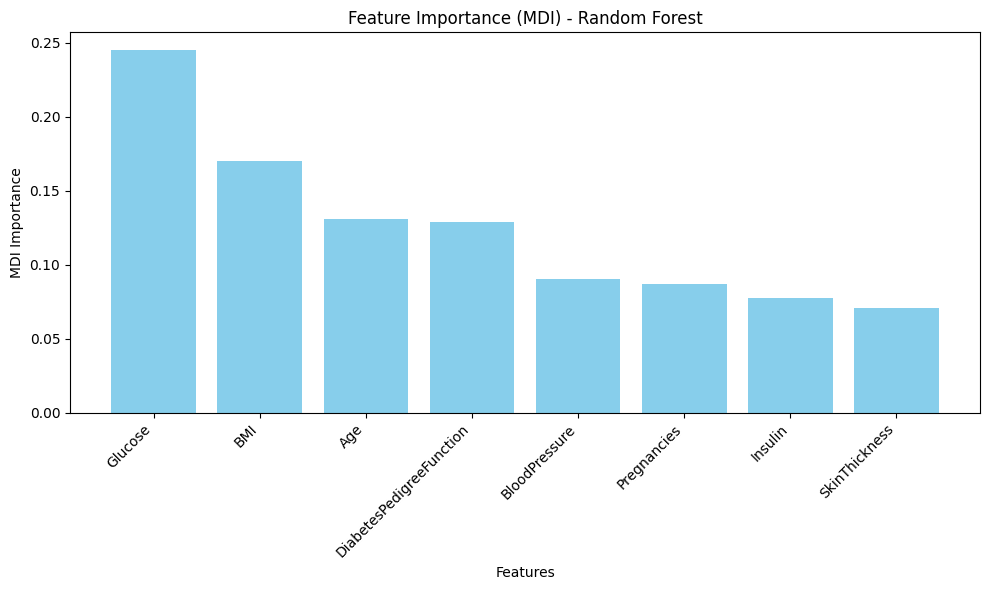

In [34]:
rft = RandomForestClassifier()
rft.fit(X,y)
mdi_importance = rft.feature_importances_

feature_names = X.columns
indices = np.argsort(mdi_importance)[::-1]  # Ordenar por importancia

plt.figure(figsize=(10, 6))
plt.bar(range(len(mdi_importance)), mdi_importance[indices], align="center", color='skyblue')
plt.xticks(range(len(mdi_importance)), [feature_names[i] for i in indices], rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("MDI Importance")
plt.title("Feature Importance (MDI) - Random Forest")
plt.tight_layout()
plt.show()

# MDA

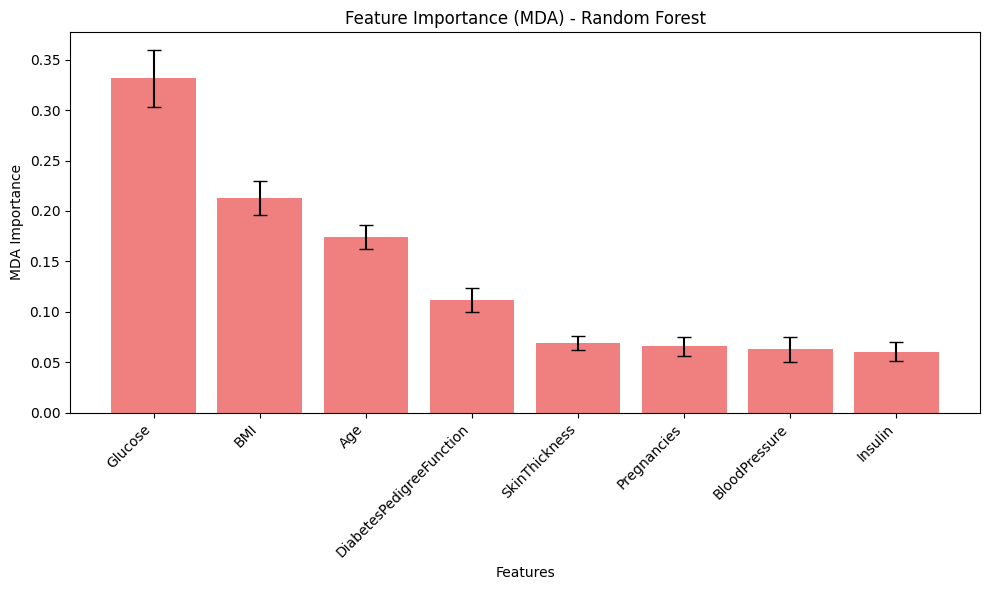

In [35]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rft, X, y, scoring="recall", n_repeats=10, random_state=42)
importance_means = perm_importance.importances_mean
importance_stds = perm_importance.importances_std
indices = np.argsort(importance_means)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importance_means)), importance_means[indices], yerr=importance_stds[indices], align="center", color="lightcoral", capsize=5)
plt.xticks(range(len(importance_means)), [feature_names[i] for i in indices], rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("MDA Importance")
plt.title("Feature Importance (MDA) - Random Forest")
plt.tight_layout()
plt.show()